In [1]:
import tqdm
import os
import sys
sys.path.append('../src/')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
import seaborn as sns
%matplotlib inline

from util import *

%load_ext autoreload
%autoreload 2
%aimport util

In [2]:
images_folder = '/media/aleksandar/Data/TT/BladeOnly/train/'

image_pairs = list(get_image_pairs(images_folder))


Since the search space in an image for a standard sliding windows technique is huge, due to large image sizes (and this holds when we only search the blade outline as well), we must find a way to get region proposals and not use any sliding windows techniques in the process if we want to get optimal performance for the model. 

In this notebook, we will see how we can use computer vision to get proposed regions which can lower the search space more than 200 times.

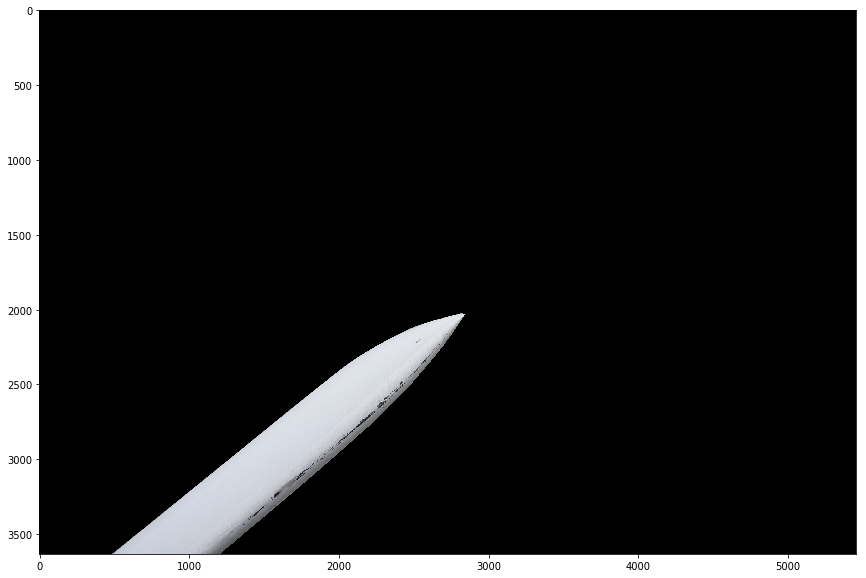

In [3]:
rand_jpg_file, rand_png_file = image_pairs[np.random.randint(len(image_pairs))]
rand_jpg, rand_png = load_jpg(rand_jpg_file), load_png(rand_png_file)


plt.figure(figsize=(20,10))
plt.imshow(rand_jpg)

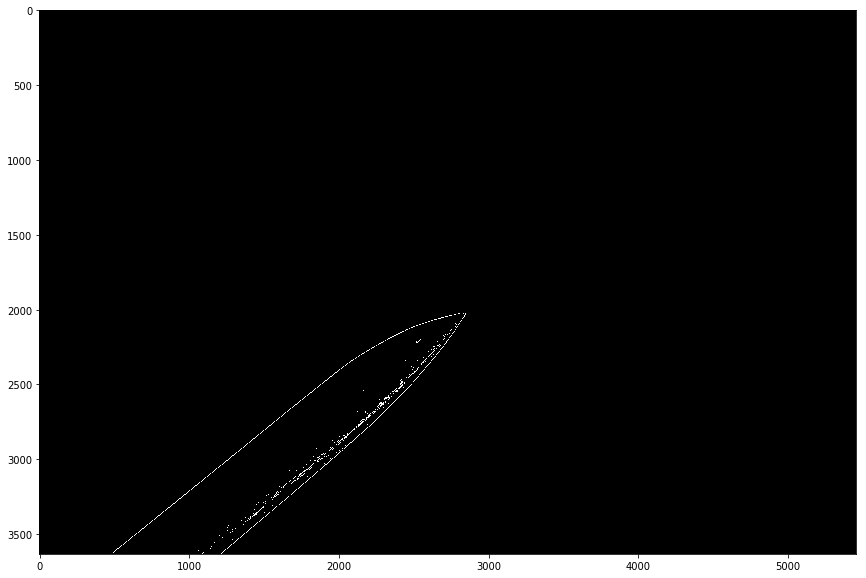

In [4]:
gaussian_kernel_size = 5
gaussian_kernel_sigma = 3
adaptive_thresh_kernel_size = 7

def get_potential_defects(img, gaussian_kernel_size, gaussian_kernel_sigma, adaptive_thresh_kernel_size):
    blurred = cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 
                               (gaussian_kernel_size, gaussian_kernel_size), gaussian_kernel_sigma)
    thresh = cv2.adaptiveThreshold(blurred, 255, 
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 
                                   adaptive_thresh_kernel_size, 2)
    thresh = thresh / 255
    
    return thresh

thresh = get_potential_defects(rand_jpg, gaussian_kernel_size, gaussian_kernel_sigma, adaptive_thresh_kernel_size)

plt.figure(figsize=(20,10))
plt.imshow(thresh, cmap='gray')


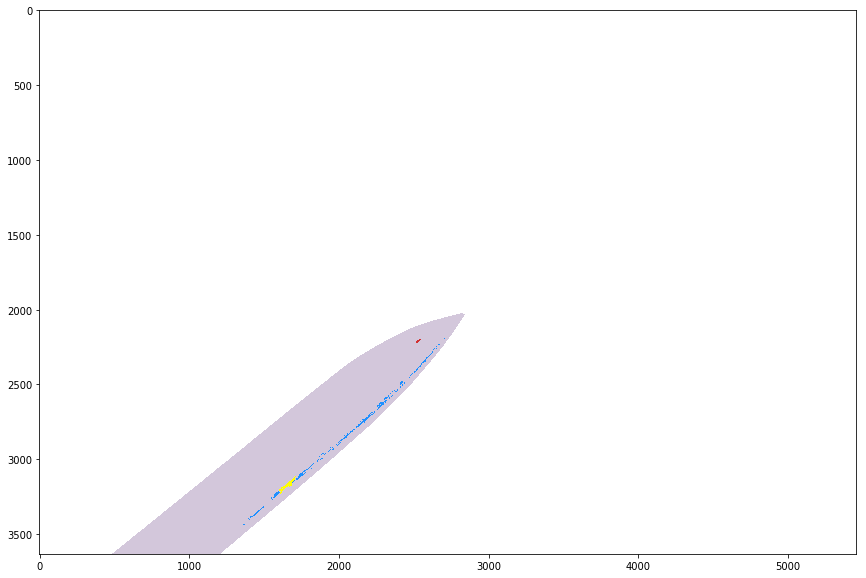

In [5]:
plt.figure(figsize=(20,10))
plt.imshow(rand_png, cmap='gray')

In [6]:
def intersection_over_union(target, pred):
    target = (target[0], target[1], target[0] + target[2], target[1] + target[3])
    pred = (pred[0], pred[1], pred[0] + pred[2], pred[1] + pred[3])
    
    # Check if rectangles overlap at all, and return 0 if not
    if target[0] > pred[2] or pred[0] > target[2] or target[3] < pred[1] or pred[3] < target[1]:
        return 0
    
    # Determine the intersecting rectangle
    inter = (max(target[0], pred[0]), max(target[1], pred[1]), min(target[2], pred[2]), min(target[3], pred[3]))
    
    inter_area = (inter[2] - inter[0]) * (inter[3] - inter[1])
    
    target_area = (target[2] - target[0]) * (target[3] - target[1])
    pred_area = (pred[2] - pred[0]) * (pred[3] - pred[1])
    
    union_area = target_area + pred_area - inter_area

    return inter_area / union_area

def intersection_over_target(target, pred):
    target = (target[0], target[1], target[0] + target[2], target[1] + target[3])
    pred = (pred[0], pred[1], pred[0] + pred[2], pred[1] + pred[3])
    
    # Check if rectangles overlap at all, and return 0 if not
    if target[0] > pred[2] or pred[0] > target[2] or target[3] < pred[1] or pred[3] < target[1]:
        return 0
    
    # Determine the intersecting rectangle
    inter = (max(target[0], pred[0]), max(target[1], pred[1]), min(target[2], pred[2]), min(target[3], pred[3]))
    
    inter_area = (inter[2] - inter[0]) * (inter[3] - inter[1])
    
    target_area = (target[2] - target[0]) * (target[3] - target[1])
    pred_area = (pred[2] - pred[0]) * (pred[3] - pred[1])
    
    union_area = target_area + pred_area - inter_area

    return inter_area / target_area

***Recalls***

In [21]:
####
recalls = {}
for jpg_file, png_file in tqdm.tqdm_notebook(image_pairs):
    
    jpg = cv2.resize(load_jpg(jpg_file), None, fx=1/4, fy=1/4)
    png = cv2.resize(load_png(png_file), None, fx=1/4, fy=1/4)
    
    png = leave_only_labels(png, ['Surface Voids', 'Chipped Paint', 'Peeling Paint'])
    png = cv2.cvtColor(png, cv2.COLOR_RGB2GRAY)
    
    target = png != 255
    defect_pixel_counts = target.sum()
    
    findings = get_potential_defects(jpg, gaussian_kernel_size, gaussian_kernel_sigma, 
                                     adaptive_thresh_kernel_size)
    findings_pixel_counts = findings.sum()
    
    if target.ravel().size != findings.ravel().size:
        print (jpg_file + ' does not have matching sizes between jpg and png.')
    
    recall = recall_score(target.ravel(), findings.ravel())

    recalls[jpg_file] = (recall, defect_pixel_counts, findings_pixel_counts)
    
recalls = pd.DataFrame(list(recalls.values()), index=list(recalls.keys()), columns=['Recall', 'DefectPixels', 'FindingsPixels'])

valid_recalls = recalls[(recalls.DefectPixels > 0)]
    

/home/aleksandar/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [22]:

valid_recalls.Recall.describe()

count    408.000000
mean       0.672048
std        0.341960
min        0.000000
25%        0.443798
50%        0.766369
75%        1.000000
max        1.000000
Name: Recall, dtype: float64

In [ ]:
sns.regplot('DefectPixels', 'Recall', data=valid_recalls)

In [ ]:
sns.distplot(valid_recalls.Recall)

***Intersection over Target***

In [25]:
####
window_width = 50
window_height = 50

max_iots = []
for jpg_file, png_file in tqdm.tqdm_notebook(image_pairs):
    
    jpg = cv2.resize(load_jpg(jpg_file), None, fx=1/4, fy=1/4, interpolation=cv2.INTER_CUBIC)
    png = cv2.resize(load_png(png_file), None, fx=1/4, fy=1/4, interpolation=cv2.INTER_NEAREST)
    
    png = leave_only_labels(png, ['Surface Voids', 'Chipped Paint', 'Peeling Paint'])
    png = cv2.cvtColor(png, cv2.COLOR_RGB2GRAY)
    
    target = png != 255
    defect_pixel_counts = target.sum()
    
    findings = get_potential_defects(jpg, gaussian_kernel_size, gaussian_kernel_sigma, 
                                     adaptive_thresh_kernel_size)
    findings_pixel_counts = findings.sum()
    
    if target.ravel().size != findings.ravel().size:
        print (jpg_file + ' does not have matching sizes between jpg and png.')
    
    target_bboxes = get_bboxes(target.astype(np.uint8))
    #findings_bboxes = get_bboxes(findings.astype(np.uint8))
    findings_bboxes = [(x + w/2 - window_width / 2,y + h/2 - window_height / 2,window_width,window_height) for x,y,w,h in get_bboxes(findings.astype(np.uint8))]
    
    for target_bbox in target_bboxes:
        max_iot = 0
        for findings_bbox in findings_bboxes:
            iou = intersection_over_target(target_bbox, findings_bbox)
            
            max_iot = max(max_iot, iou)
        
        max_iots.append(max_iot)
    
    
max_iots = np.array(max_iots)

In [27]:
pd.Series(max_iots).describe()

count    1954.000000
mean        0.832196
std         0.372233
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64

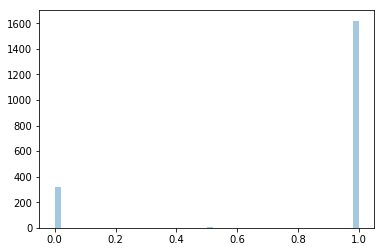

In [28]:
sns.distplot(max_iots, bins=50, kde=False)

In [30]:
# How many are less than 1?

(max_iots < 0.001).mean()

0.1653019447287615

In [34]:
(max_iots < 1).mean() * len(max_iots)

334.0